# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">Data preprocessor for categorical data</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from xbooster._utils import DataPreprocessor
from pprint import pprint

# Load dataset
dataset = pd.read_csv("data/train_u6lujuX_CVtuZ9i.csv", index_col=False)

# Define features, numerical features, and target variable
numerical_features = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
]
categorical_features = [
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Property_Area",
]
target = "Loan_Status"

preprocessor = DataPreprocessor(numerical_features, categorical_features, target)

# Preprocess data
X, y = preprocessor.fit_transform(dataset)

# Save names of new one-hot encoded features
features_ohe = [col for col in X.columns if col not in numerical_features]
interaction_constraints = preprocessor.generate_interaction_constraints(features_ohe)

# Split data into train and test sets
ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)

pprint(interaction_constraints)

[['Married_No', 'Married_Yes', 'Married_nan'],
 ['Dependents_0',
  'Dependents_1',
  'Dependents_2',
  'Dependents_3+',
  'Dependents_nan'],
 ['Education_Graduate', 'Education_Not Graduate'],
 ['Self_Employed_No', 'Self_Employed_Yes', 'Self_Employed_nan'],
 ['Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']]


In [3]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score  # type: ignore

best_params = dict(
    n_estimators=50,
    learning_rate=0.3,
    max_depth=2,
    subsample=0.8,
    min_child_weight=1,
    grow_policy="lossguide",
    interaction_constraints=interaction_constraints,
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\nTest Gini score: {gini_tst:.2%}")

Train Gini score: 67.44%
Test Gini score: 61.09%


In [4]:
from xbooster.constructor import XGBScorecardConstructor

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])

# Construct the scorecard
xgb_scorecard = scorecard_constructor.construct_scorecard()

# Create a scorecard with points
xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50,
    target_points=600,
    target_odds=50,  # score_type='WOE'
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(X.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore

print(f"Test Gini score: {gini:.2%}")

Test Gini score: 61.65%


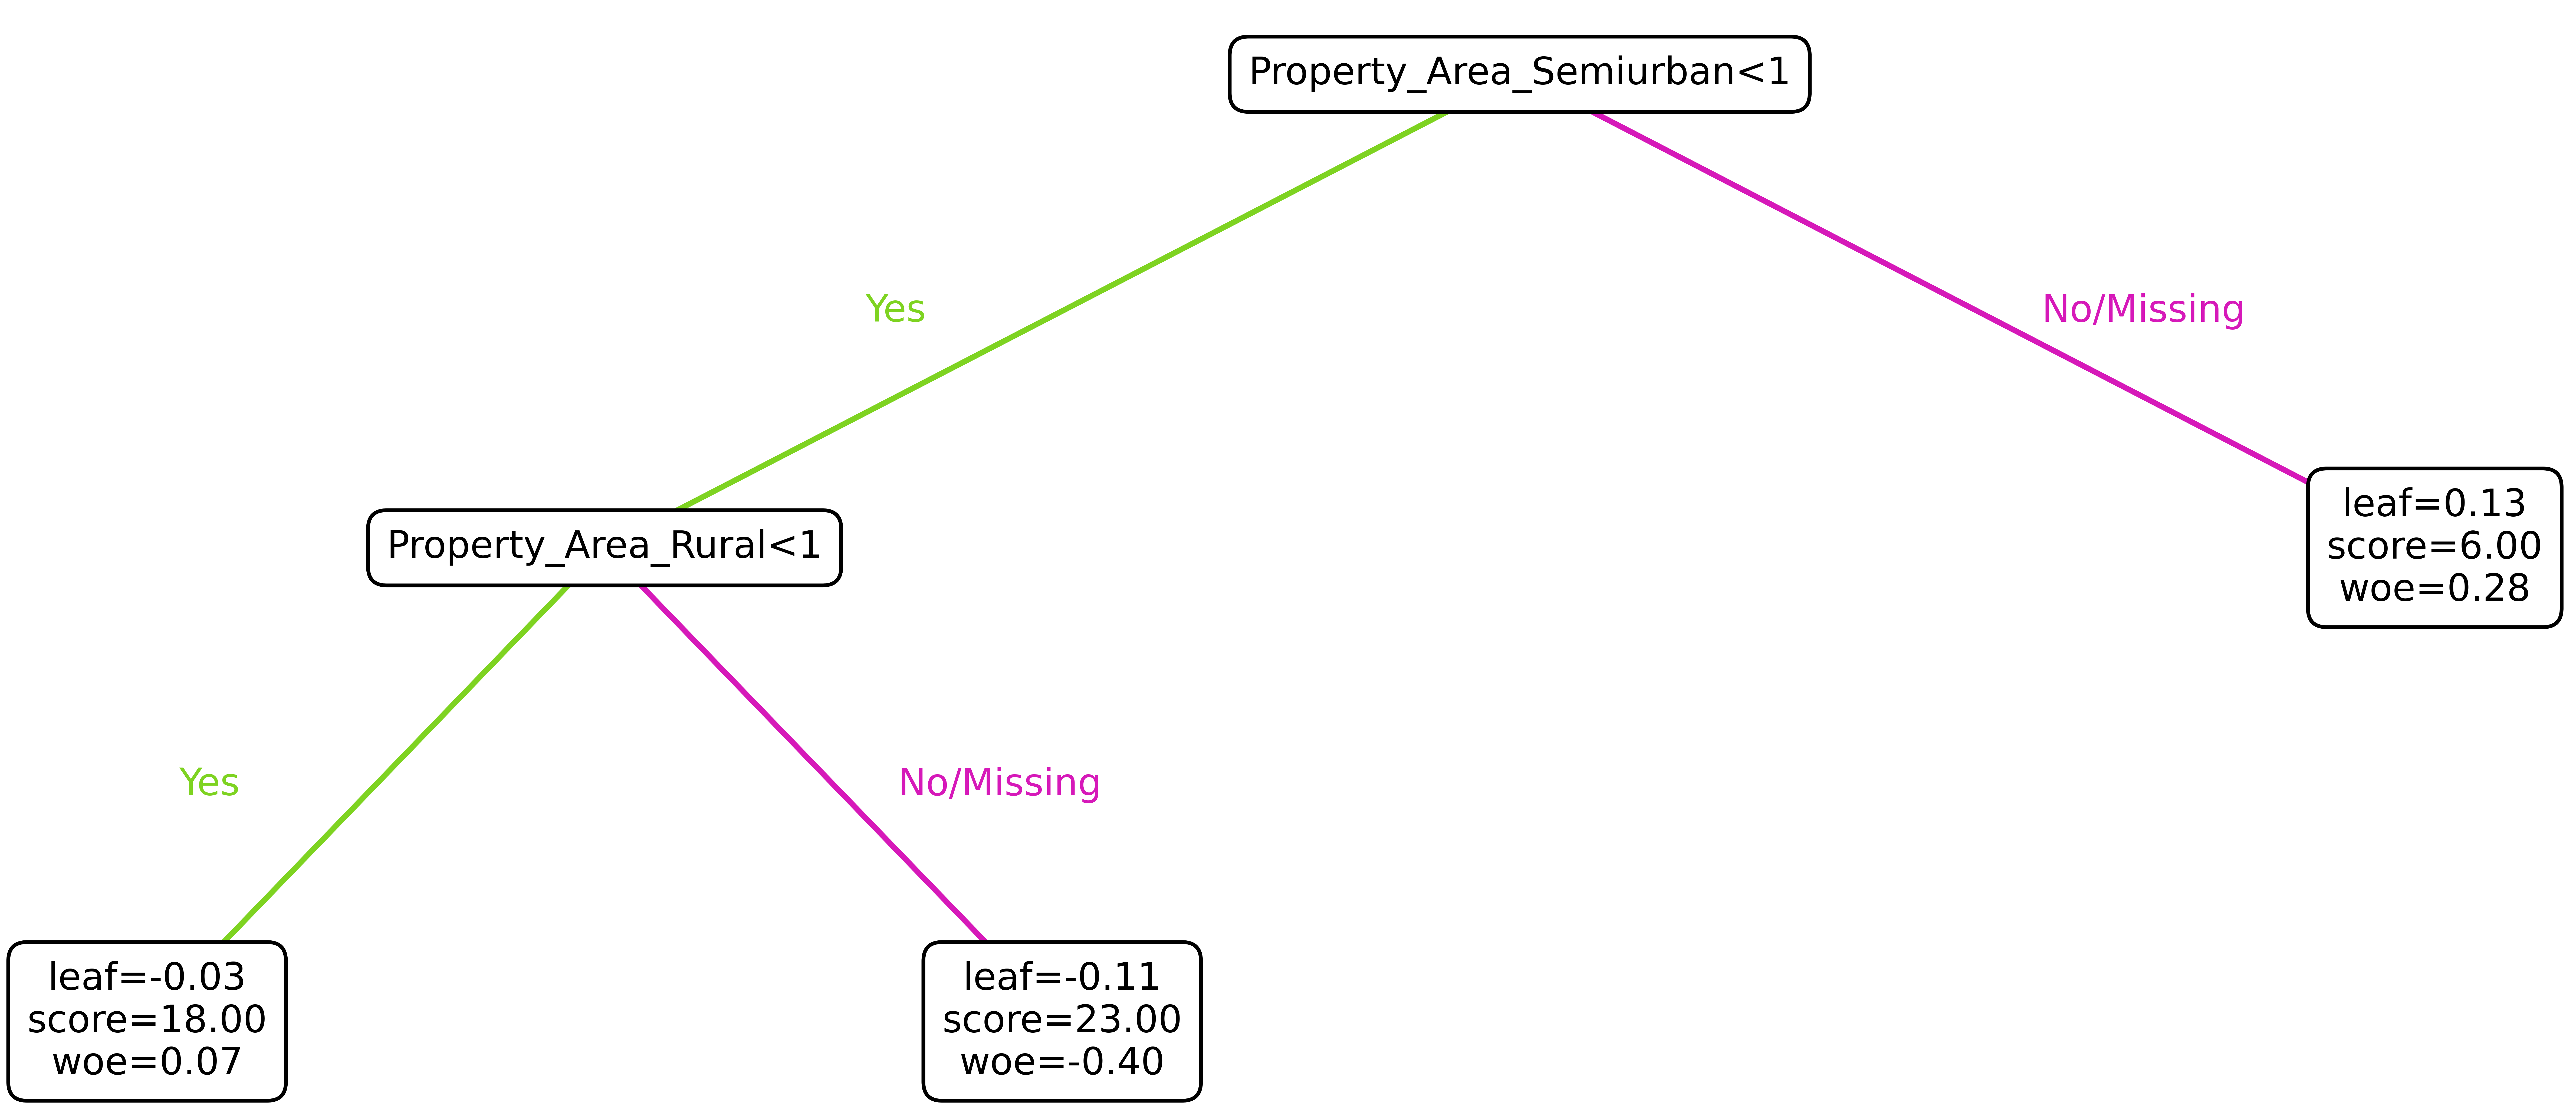

In [13]:
from xbooster.explainer import TreeVisualizer
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

tree_viz = TreeVisualizer(metrics=["Points", "WOE"], precision=2)

tree_id = 5

plt.figure(figsize=(12, 5), dpi=500)
tree_viz.plot_tree(
    scorecard_constructor,
    num_trees=tree_id,
    facecolor="white",
    edgecolor="black",
)
plt.show()